In [1]:
%matplotlib inline

import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from torch.utils.data import DataLoader
import torch
from typing import List, Literal
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score
import re

from predpy.dataset import MultiTimeSeriesDataset
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator, load_last_experimentator)
from predpy.plotter import plot_anomalies, get_ids_ranges, get_cls_ids_ranges
from anomaly_detection import (
    AnomalyDetector, fit_run_detection, exp_fit_run_detection,
    get_dataset, get_train_test_ds, get_dataset_names, load_anom_scores,
    MovingStdAD
)

from notebook_utils.modeling import (
    predict, get_a_scores, get_rec_fbeta_score_conf_mat,
    get_a_scores_one_per_point, get_recon_one_per_point,
    adjust_point_cls_with_window,
    th_ws_experiment, stats_experiment,
    calculate_rec_wdd, recalculate_wdd
)
from notebook_utils.plotting import (
    plot_scores, plot_kde, plot_dataset, plot_scores_and_bands
)
from notebook_utils.save_load import (
    save_th_exp, load_th_exp
)
from notebook_utils.ts_stats import (
    get_bollinger, get_std, get_diff
)


os.chdir('/home/stachu/Projects/Anomaly_detection/TSAD')
sns.set_style()

# Data and model loading

In [2]:
# exp = load_experimentator('./saved_experiments/2022-06-05_16:27:49.pkl')
exp = load_experimentator('./saved_experiments/2022-06-11_03:12:37.pkl')
# exp = load_experimentator('./saved_experiments/2022-06-05_17:34:24.pkl')
model_id = 0
ds_id = 0
exp.models_params

,name_,cls_,init_params,WrapperCls,wrapper_kwargs,learning_params
0,AnomTrans_l3_d512_lambda3,<class 'literature.anom_trans.anom_trans.Anoma...,"{'window_size': 100, 'c_in': 38, 'd_model': 51...",<class 'literature.anom_trans.anom_trans_wrapp...,{},"{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."


In [3]:
m_name = 'AnomTrans_l3_d512_lambda3'
# m_name = 'AnomTrans_l2'
topic, collection_name, ds_name = 'Industry', 'ServerMachineDataset', 'machine-1-1'
exp_date = exp.exp_date
model = exp.load_pl_model(model_id, f'checkpoints/{ds_name}/{m_name}')
window_size = exp.datasets_params.loc[ds_id]['window_size']
ts_scaler = exp.datasets_params.loc[ds_id]['scaler']
scores_dirpath = f'notebook_a_scores/{collection_name}/{ds_name}/{m_name}/{exp_date}/'

In [4]:
train_ds, test_ds = get_train_test_ds(
    topic=topic, collection_name=collection_name, ds_name=ds_name,
    window_size=window_size, ts_scaler=ts_scaler, fit_scaler=True)

train_dl = DataLoader(train_ds, batch_size=1)
test_dl = DataLoader(test_ds, batch_size=1)
test_index = test_ds.sequences[0].index

test_point_cls_path = f'data/{topic}/{collection_name}/test_label/{ds_name}.csv'
test_point_cls = pd.read_csv(
    test_point_cls_path, header=None)\
    .iloc[:, 0].to_numpy()

n_features = train_ds.sequences[0].shape[1]

## Load scores

In [6]:
a_scores = np.load(scores_dirpath + 'a_point_scores.npy', allow_pickle=True)
x_hat = np.load(scores_dirpath + 'x_hat.npy', allow_pickle=True)
x_hat_err_points = np.load(scores_dirpath + 'x_hat_err_points.npy', allow_pickle=True)

# Dataset plotting

Plotting "machine-1-1" dataset.  
Blue is training dataset, orange is test dataset.  
Anomalies are red regions, they are present only in test dataset.  
Not all features express anomalies.  

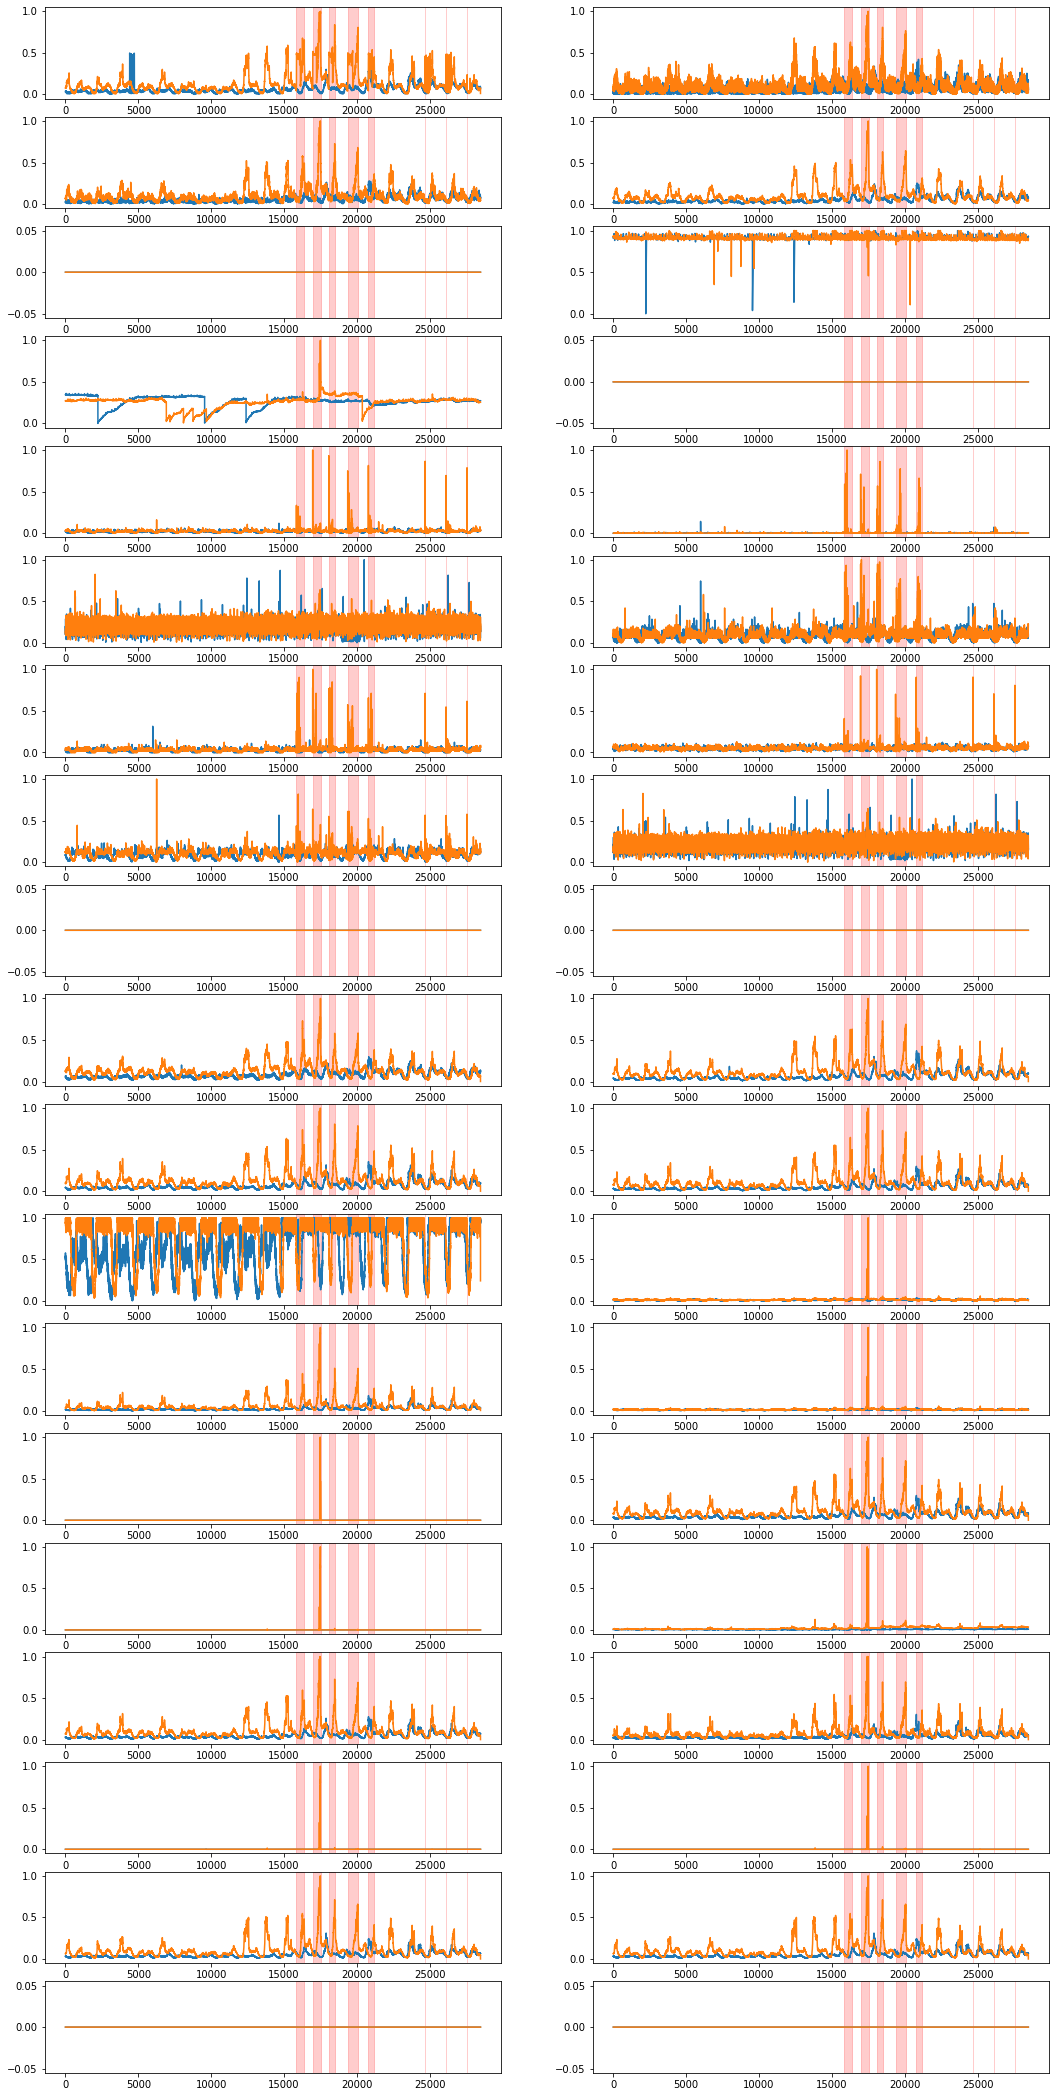

In [29]:
anoms_vrects = [
    (15849, 16368), (16963, 17517), (18071, 18528), (19367, 20088),
    (20786, 21195), (24679, 24682), (26114, 26116), (27554, 27556)]

plot_dataset(
    train_ds=train_dl.dataset.sequences[0].to_numpy(),
    test_ds=test_dl.dataset.sequences[0].to_numpy(),
    anoms_vrects=anoms_vrects);


# Collecting and storing anomaly scores

In [6]:
# test_as, pred_cls = load_anom_scores(
#     f'saved_scores_preds/ServerMachineDataset/machine-1-1/{m_name}/anom_scores.csv')

## Computing anomaly score

Anomaly scores

In [6]:
a_scores = get_a_scores_one_per_point(
    model=model, dataloader=DataLoader(test_ds, batch_size=1), ws=window_size,
    return_only_a_score=True
)

100%|██████████| 28380/28380 [00:39<00:00, 726.97it/s]



Reconstruction error

In [6]:
x_hat = get_recon_one_per_point(
    model=model, dataloader=DataLoader(test_ds, batch_size=1), ws=window_size
)
x_all = test_ds.sequences[0].to_numpy()
x_hat_err_points = np.abs(x_hat - x_all)

100%|██████████| 28380/28380 [00:28<00:00, 980.53it/s] 


## Saving scores

In [26]:
os.makedirs(scores_dirpath, exist_ok=True)

a_scores.dump(scores_dirpath + 'a_point_scores.npy')
x_hat.dump(scores_dirpath + 'x_hat.npy')
x_hat_err_points.dump(scores_dirpath + 'x_hat_err_points.npy')

# Plotting scores

## KDE over train and test datasets

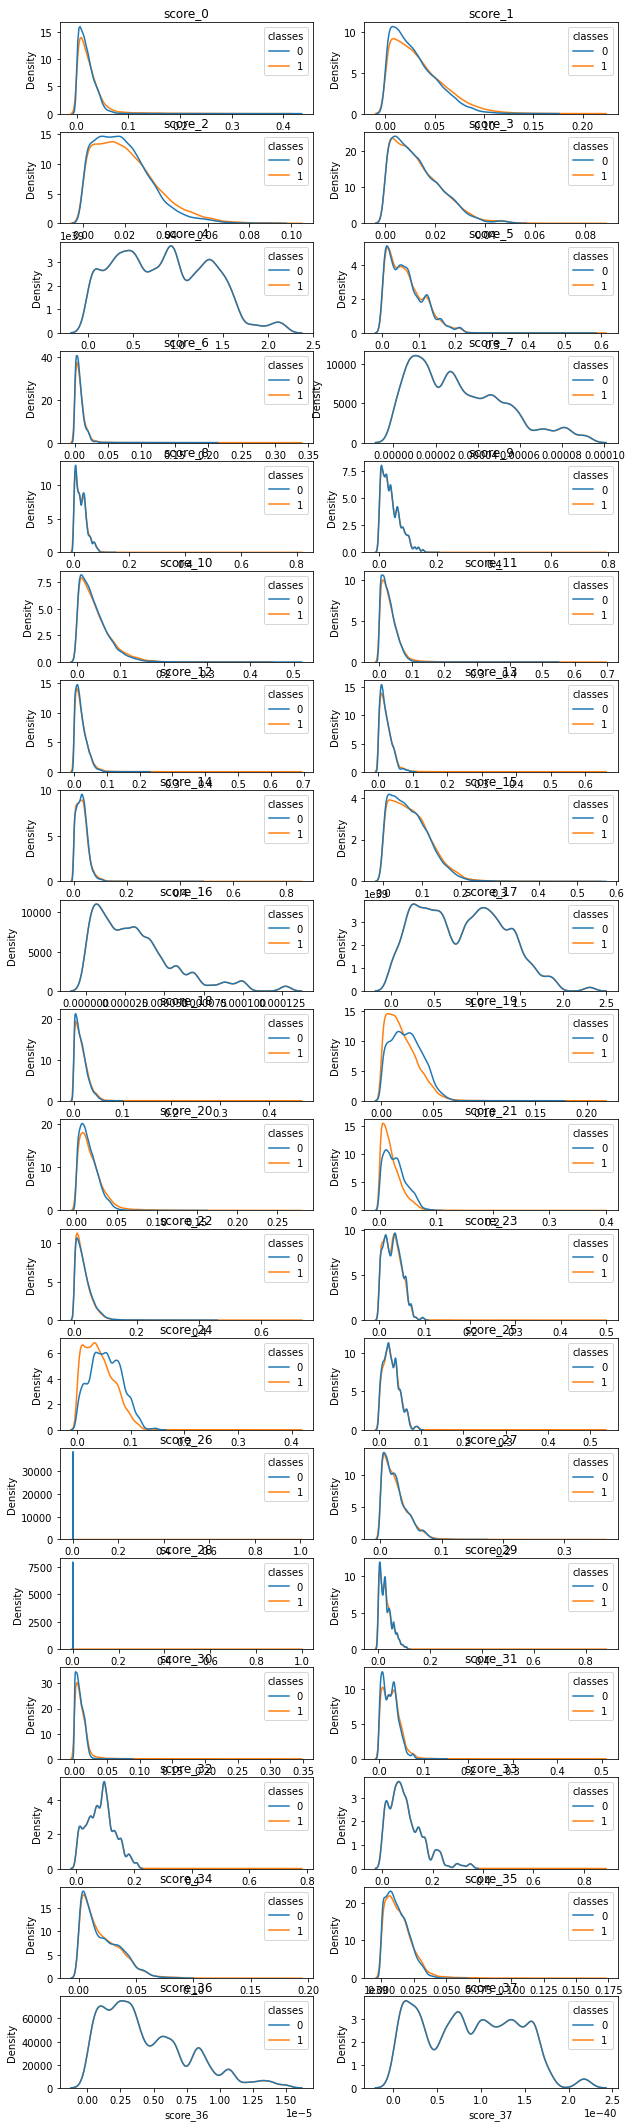

In [17]:
plot_kde(x_hat_err_points_st, scores2=x_hat_err_points);

## Anomaly score and rec err for points

Anomaly score

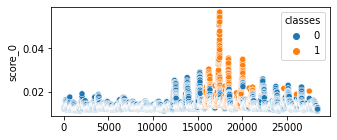

In [304]:
plot_scores(a_scores, classes=test_point_cls);

Recon error

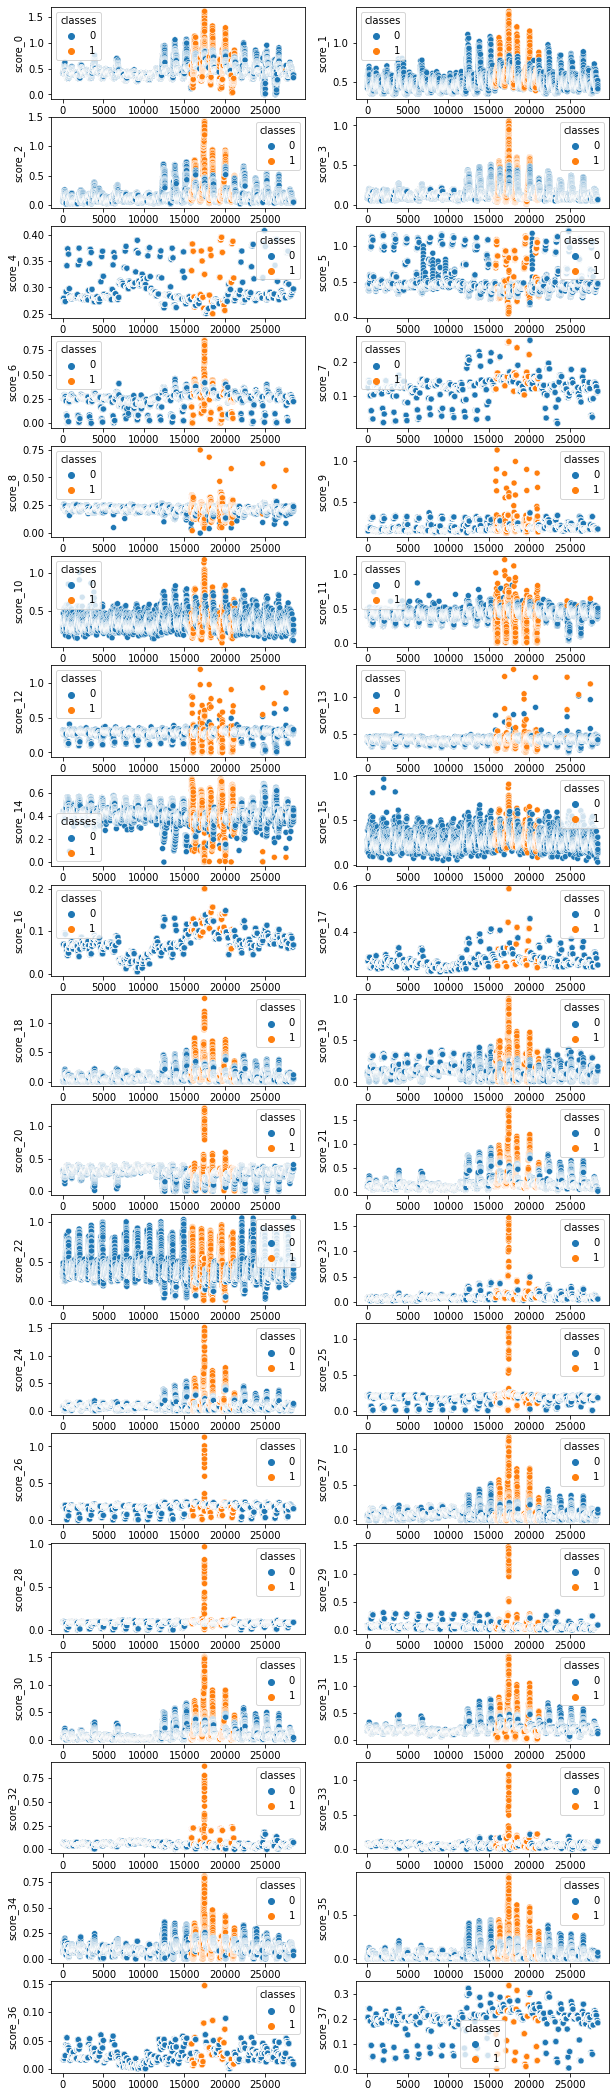

In [305]:
plot_scores(x_hat_err_points, classes=test_point_cls);

# Finding best ws and th
ws - window size  
th - threshold  
Optimizing beta score.  

## Loading computed scores

In [7]:
th_df = load_th_exp(scores_dirpath + 'th_ws_exp.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'notebook_a_scores/ServerMachineDataset/machine-1-1/AnomTrans_l3_d512_lambda3/2022-06-05_16:27:49/th_ws_exp.csv'

## Computing and comparing scores

In [7]:
ws = 200
betas = [0.5, 1]
wss = [200, 500]  # np.arange(100, 501, 100)
ths = np.linspace(0.01, 0.3, 50)
th_df = th_ws_experiment(
    series_index=test_index, point_scores=a_scores,
    point_cls=test_point_cls, t_max=None,
    ths=ths, wss=wss, betas=betas)

100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Saving scores

In [10]:
save_th_exp(th_df, scores_dirpath + 'th_ws_exp.csv')

Best f1-score for model window size

In [8]:
th_df[th_df['ws'] == ws].sort_values('f1-score', ascending=False).head()

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
1,200,0.015918,None,0.617463,0.716732,17976,4426,123,5755,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,200,0.021837,None,0.535258,0.450489,21074,1328,3783,2095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,200,0.027755,None,0.605369,0.380270,22402,0,4498,1380,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,200,0.010000,None,0.246979,0.344165,0,22402,0,5878,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,200,0.033673,None,0.315441,0.155632,22402,0,5382,496,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [45]:
th_df[th_df['ws'] == ws].sort_values('f1-score', ascending=False).head()

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
2,200,0.021837,None,0.569463,0.630150,18489,3913,1374,4504,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,200,0.027755,None,0.646668,0.484315,21999,403,3871,2007,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,200,0.015918,None,0.283989,0.388230,3877,18525,0,5878,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,200,0.033673,None,0.604236,0.379153,22402,0,4503,1375,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,200,0.010000,None,0.246979,0.344165,0,22402,0,5878,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


Best f0.5-score for model window size

In [17]:
th_df[th_df['ws'] == ws].sort_values('f0.5-score', ascending=False).head()

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
0,200,0.250000,None,0.0,0.0,22401,0,5878,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37,200,1.005102,None,0.0,0.0,22401,0,5878,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,200,0.801020,None,0.0,0.0,22401,0,5878,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28,200,0.821429,None,0.0,0.0,22401,0,5878,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29,200,0.841837,None,0.0,0.0,22401,0,5878,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Best f1-score for every window size

In [18]:
th_df.loc[th_df.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
0,200,0.25,None,0.0,0.0,22401,0,5878,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50,500,0.25,None,0.0,0.0,18709,0,9270,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Best f0.5-score for every window size

In [11]:
th_df.loc[th_df.groupby(['ws'])['f0.5-score'].idxmax()]

,f0.5-score,f1-score,ws,th,tn,fp,fn,tp
9,0.774770,0.757012,100,0.433673,23338,847,1163,3131
65,0.803443,0.770221,200,0.556122,21698,887,1647,4247
115,0.847983,0.834026,300,0.556122,20063,1000,1396,6020
165,0.861993,0.864622,400,0.556122,18763,1202,1115,7399
215,0.867261,0.883328,500,0.556122,17702,1424,828,8525


# Plotting with best th

In [1]:
# pred_cls = predict(x_hat1_err_points, 0.43, window_size)
# true_cls = adjust_point_cls_with_window(test_point_cls, window_size)
# pred_anom_intervals = get_ids_ranges(np.where(pred_cls == 1)[0])
# true_anom_intervals = get_ids_ranges(np.where(true_cls == 1)[0])
# plot_anomalies(
#     time_series=test_ds.sequences[0], predictions=pd.DataFrame(x_hat1),
#     pred_anomalies_intervals=pred_anom_intervals, true_anomalies_intervals=true_anom_intervals,
#     is_ae=False)

# Searching for descriptive statistics

## Moving std diff

### Loading scores

In [13]:
std_th_df = load_th_exp(scores_dirpath + 'std_th_exp-long_ws.csv')

### Computing and comparing scores

In [9]:
# bounds = [
#     get_diff(get_bollinger(x_hat1_err_points, ws, m))
#     for ws, m in [(100, 30), (200, 30), (300, 30), (400, 30)]
# ]
# ws_list = [100, 200, 300, 400]
ws_list = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
bounds = [
    get_diff(get_std(a_scores, ws))
    for ws in ws_list
]

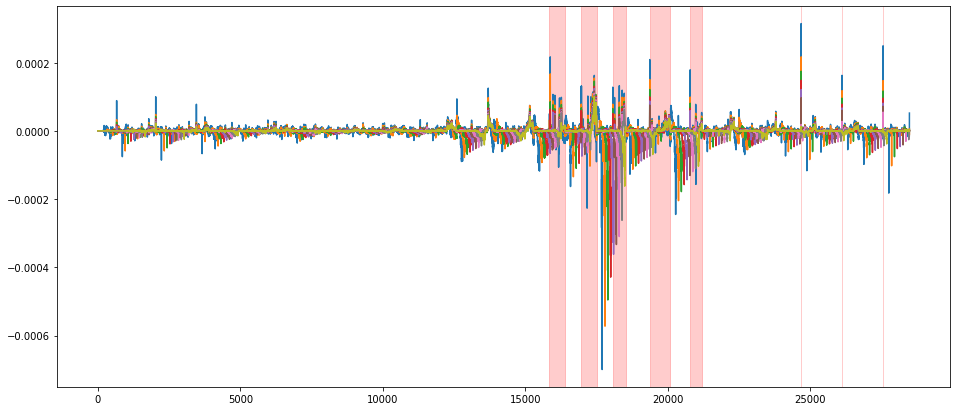

In [10]:
plot_dataset(
    {b.name: b for b in bounds},
    get_ids_ranges(np.where(test_point_cls == 1)[0]),
    figsize=(16, 7),  # min_id=24600, max_id=24750
);

In [24]:
betas = [0.5, 1]
ths = np.linspace(0.00001, 0.00015, 40)

std_th_df5 = stats_experiment(
    series_index=test_index, t_max=None, scores_are_points=True,
    scores_list=bounds, point_cls=test_point_cls, ths_list=[ths] * len(ws_list),
    ws_list=ws_list, betas=betas)

100%|██████████| 9/9 [00:33<00:00,  3.72s/it]


In [12]:
save_th_exp(std_th_df, scores_dirpath + 'std_th_exp-long_ws.csv')

In [25]:
# 2022-06-11_03:12:37
std_th_df5.loc[std_th_df5.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
29,200,0.000114,None,0.861252,0.795165,22001,401,1734,4144,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
63,300,0.000093,None,0.958464,0.902652,20774,2,1312,6092,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99,400,0.000078,None,0.970588,0.929928,19574,2,1112,7392,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
137,500,0.000071,None,0.979942,0.951482,18709,1,857,8413,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
175,600,0.000064,None,0.976754,0.943996,18009,1,1046,8824,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
213,700,0.000057,None,0.948149,0.879867,17309,1,2245,8225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
247,800,0.000035,None,0.748535,0.797145,13188,3748,1140,9604,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
284,900,0.000024,None,0.590330,0.687672,7775,8861,566,10378,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
324,1000,0.000024,None,0.643125,0.694394,10701,5635,2220,8924,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [76]:
# 2022-06-05_16:27:49.pkl
std_th_df5.loc[std_th_df5.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
22,200,0.000089,None,0.941662,0.866641,22399,3,1381,4497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50,300,0.000046,None,0.912070,0.906959,20162,614,751,6653,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
89,400,0.000042,None,0.925304,0.932838,18880,696,462,8042,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
130,500,0.000046,None,0.990090,0.975750,18709,1,438,8832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169,600,0.000042,None,0.982085,0.956384,18010,0,825,9045,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
208,700,0.000039,None,0.965823,0.918724,17310,0,1574,8896,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
243,800,0.000021,None,0.863884,0.890801,15110,1826,649,10095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
283,900,0.000021,None,0.743537,0.688004,14811,1825,4248,6696,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
322,1000,0.000017,None,0.739561,0.680297,14506,1830,4456,6688,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [88]:
std_th_df5.loc[std_th_df5.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
29,200,0.000114,None,0.861252,0.795165,22001,401,1734,4144,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
63,300,0.000093,None,0.958464,0.902652,20774,2,1312,6092,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99,400,0.000078,None,0.970588,0.929928,19574,2,1112,7392,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
137,500,0.000071,None,0.979942,0.951482,18709,1,857,8413,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
175,600,0.000064,None,0.976754,0.943996,18009,1,1046,8824,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
213,700,0.000057,None,0.948149,0.879867,17309,1,2245,8225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
247,800,0.000035,None,0.748535,0.797145,13188,3748,1140,9604,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
284,900,0.000024,None,0.590330,0.687672,7775,8861,566,10378,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
324,1000,0.000024,None,0.643125,0.694394,10701,5635,2220,8924,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [58]:
std_th_df3.loc[std_th_df3.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
5,200,0.000028,None,0.547644,0.645612,16937,5465,471,5407,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
45,300,0.000028,None,0.691337,0.658801,18972,1804,2881,4523,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
84,400,0.000024,None,0.881446,0.748529,19575,1,3417,5087,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
123,500,0.000021,None,0.882073,0.749494,18710,0,3714,5556,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
161,600,0.000014,None,0.689616,0.764093,13004,5006,673,9197,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
201,700,0.000014,None,0.733518,0.735942,14472,2838,2722,7748,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
241,800,0.000014,None,0.727962,0.740958,13738,3198,2539,8205,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
280,900,0.000010,None,0.667237,0.753707,10183,6453,423,10521,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
320,1000,0.000010,None,0.764326,0.827151,12335,4001,463,10681,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [48]:
std_th_df2.loc[std_th_df2.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
22,200,0.000089,None,0.941662,0.866641,22399,3,1381,4497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50,300,0.000046,None,0.912070,0.906959,20162,614,751,6653,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
89,400,0.000042,None,0.925304,0.932838,18880,696,462,8042,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
130,500,0.000046,None,0.990090,0.975750,18709,1,438,8832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169,600,0.000042,None,0.982085,0.956384,18010,0,825,9045,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
208,700,0.000039,None,0.965823,0.918724,17310,0,1574,8896,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
243,800,0.000021,None,0.863884,0.890801,15110,1826,649,10095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
283,900,0.000021,None,0.743537,0.688004,14811,1825,4248,6696,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
322,1000,0.000017,None,0.739561,0.680297,14506,1830,4456,6688,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
std_th_df.loc[std_th_df.groupby(['ws'])['f1-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
26,200,0.000103,None,0.865708,0.803354,22000,402,1662,4216,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
53,300,0.000057,None,0.854593,0.870237,19552,1224,758,6646,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
91,400,0.000049,None,0.858648,0.886553,18069,1507,533,7971,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
134,500,0.000060,None,0.894183,0.896114,17710,1000,933,8337,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
169,600,0.000042,None,0.854904,0.890972,16106,1904,411,9459,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
213,700,0.000057,None,0.948236,0.879914,17310,0,2245,8225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
243,800,0.000021,None,0.659497,0.756034,10002,6934,0,10744,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
281,900,0.000014,None,0.659436,0.755984,9571,7065,0,10944,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
321,1000,0.000014,None,0.652235,0.742217,9278,7058,403,10741,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [29]:
std_th_df.loc[std_th_df.groupby(['ws'])['f0.5-score'].idxmax()]

,ws,th,wdd,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls
17,200,0.000091,None,0.941820,0.866724,22399,2,1381,4497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
32,300,0.000067,None,0.958354,0.902408,20773,2,1315,6089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50,400,0.000057,None,0.970778,0.930189,19574,1,1109,7395,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
67,500,0.000043,None,0.990001,0.975696,18707,2,438,8832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
87,600,0.000043,None,0.982061,0.956329,18009,0,826,9044,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
106,700,0.000038,None,0.965823,0.918724,17309,0,1574,8896,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
123,800,0.000024,None,0.925054,0.913882,16240,695,1119,9625,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
145,900,0.000034,None,0.839436,0.676503,16635,0,5350,5594,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
163,1000,0.000024,None,0.765860,0.634838,15641,694,5639,5505,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Plotting best thresholds

#### WS = 500

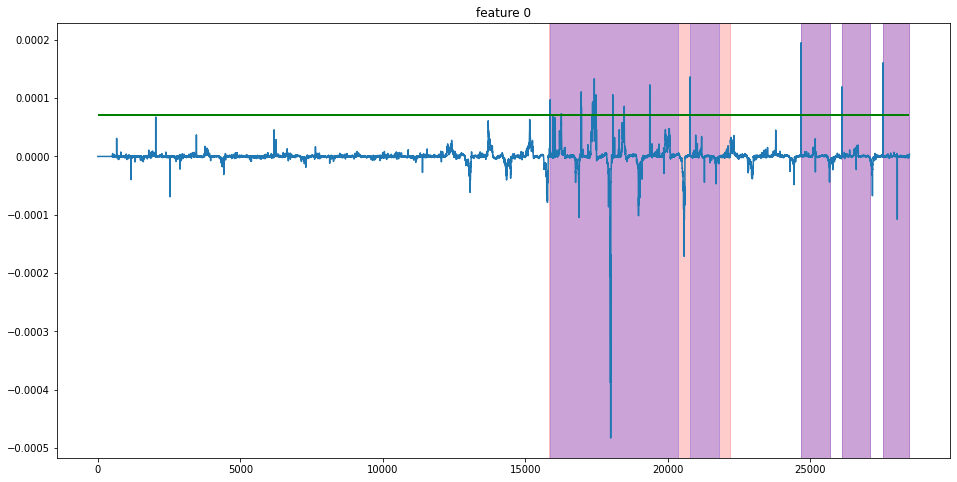

In [27]:
tmp_true_cls = adjust_point_cls_with_window(
    test_point_cls, 500, return_point_cls=False)

plot_dataset(
    ds={'std_500': bounds[3]},
    anoms_vrects=get_cls_ids_ranges(test_index, tmp_true_cls),
    pred_anoms_vrects=get_cls_ids_ranges(test_index, std_th_df5.loc[137, 'preds_rec_cls']),
    hlines={'threshold': std_th_df5.loc[137, 'th']},
    figsize=(16, 8)
);

#### WS = 400

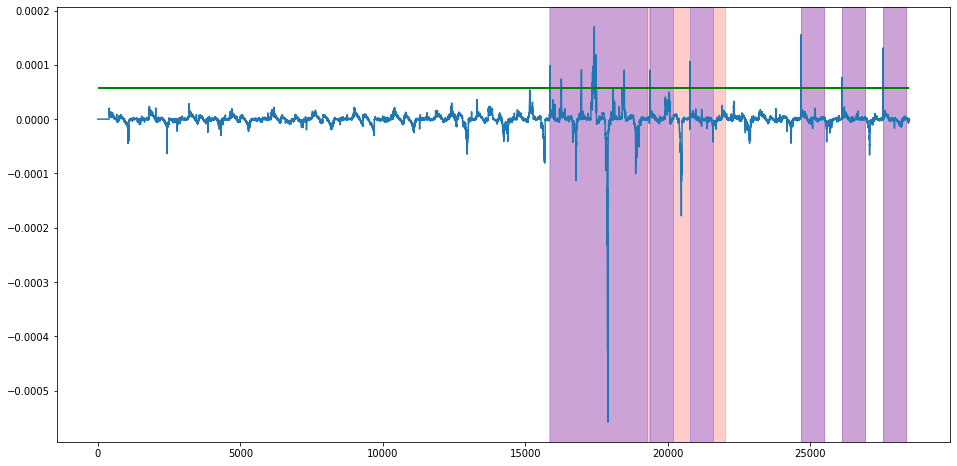

In [54]:
tmp_true_cls = adjust_point_cls_with_window(
    test_point_cls, 400, return_point_cls=False)

plot_dataset(
    ds={'std_400': bounds[2]},
    anoms_vrects=get_cls_ids_ranges(test_index, tmp_true_cls),
    pred_anoms_vrects=get_cls_ids_ranges(test_index, std_th_df.loc[50, 'preds_rec_cls']),
    hlines={'threshold': std_th_df.loc[50, 'th']},
    figsize=(16, 8)
);

#### WS = 200

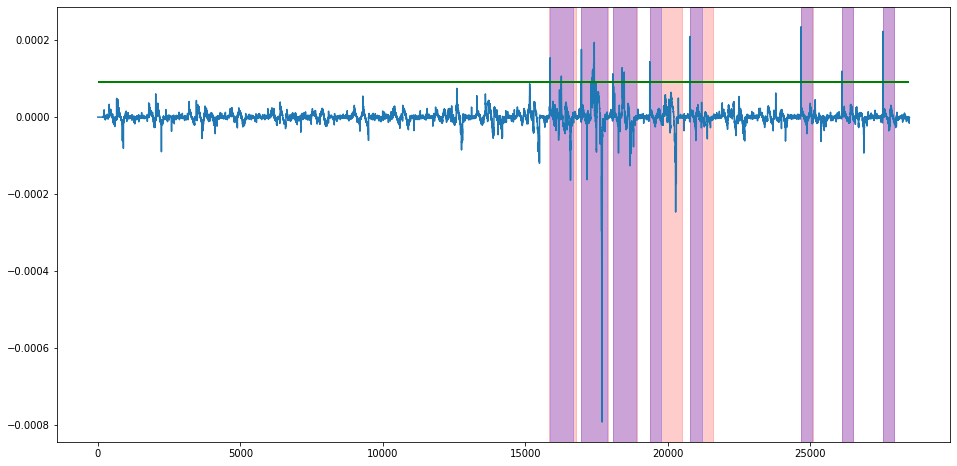

In [55]:
tmp_true_cls = adjust_point_cls_with_window(
    test_point_cls, 200, return_point_cls=False)

plot_dataset(
    ds={'std_200': bounds[0]},
    anoms_vrects=get_cls_ids_ranges(test_index, tmp_true_cls),
    pred_anoms_vrects=get_cls_ids_ranges(test_index, std_th_df.loc[17, 'preds_rec_cls']),
    hlines={'threshold': std_th_df.loc[17, 'th']},
    figsize=(16, 8)
);

In [44]:
save_th_exp(std_th_df, scores_dirpath + 'std_th_exp-long_ws.csv')

In [58]:
sub_std_th_df = std_th_df[(std_th_df['ws'] == 200) | (std_th_df['ws'] == 500)]

In [61]:
sub_std_th_df['ws'].unique()

array([200, 500])

In [75]:
sub_std_th_df.loc[sub_std_th_df.groupby(['ws'])['f0.5-score'].idxmax()]
# sub_std_th_df.sort_values('wdd', ascending=False).head()

,ws,th,f0.5-score,f1-score,tn,fp,fn,tp,preds_rec_cls,wdd
17,200,0.000091,0.941820,0.866724,22399,2,1381,4497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2267.446398
67,500,0.000043,0.990001,0.975696,18707,2,438,8832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3681.739401


In [70]:
recalculate_wdd(sub_std_th_df, test_index, test_point_cls, t_max=500)

/tmp/ipykernel_20174/4266759851.py:77: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
save_th_exp(sub_std_th_df, scores_dirpath + 'std_th_exp-200_500.csv')

/home/stachu/Projects/Anomaly_detection/TSAD/notebook_utils/save_load.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Testing MovingStdAd

In [8]:
ws = 200
best_id = std_th_df.loc[std_th_df['ws'] == ws, 'f0.5-score'].idxmax()
th = std_th_df.loc[best_id, 'th']

NameError: name 'std_th_df' is not defined

In [66]:
float(bounds_train[0][int(len_*0.8):].max()), float(bounds_train[0].max())

(4.4764209850240355e-05, 0.00013642876167946734)

<AxesSubplot:ylabel='Count'>

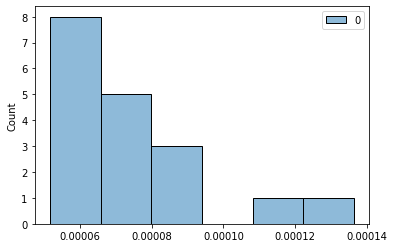

In [73]:
sns.histplot(bounds_train[0][bounds_train[0]>0.00005])
sns.histplot(bounds_train[0][int(len_*0.8):]);

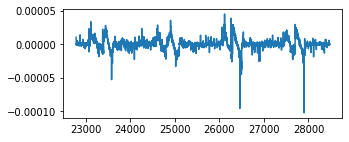

In [60]:
len_ = bounds_train[0].shape[0]
plot_dataset({"200": bounds_train[0][int(len_*0.8):]});

In [53]:
ws = 200
msad = MovingStdAD(
    stat_window_size=ws, warmup=None, threshold=0.000136, max_z_score=5
)

In [54]:
pred_cls = []
z_scores = []
for val in tqdm(bounds[ws_list.index(ws)][0].to_list()):
    p_cls, z_s = msad.predict(val, return_z_score=True)
    pred_cls += [p_cls]
    z_scores += [z_s]
pred_point_cls = np.array(pred_cls)
z_scores = np.array(z_scores)

100%|██████████| 28479/28479 [00:00<00:00, 1169411.95it/s]


In [55]:
true_cls = adjust_point_cls_with_window(test_point_cls, ws, return_point_cls=False)
pred_cls = adjust_point_cls_with_window(pred_point_cls, ws, return_point_cls=False)

In [57]:
fb_s = fbeta_score(true_cls, pred_cls, beta=0.5)
cm = confusion_matrix(true_cls, pred_cls)
fb_s, cm

(0.8212743610689696,
 array([[22401,     0],
        [ 3063,  2815]]))

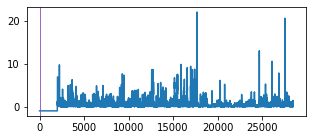

In [88]:
plot_dataset(
    ds={"z_scores": z_scores.reshape(-1, 1)},
    anoms_vrects=get_ids_ranges(test_point_cls.tolist()),
    pred_anoms_vrects=get_ids_ranges(pred_cls.tolist())
);

In [87]:
np.argwhere(test_point_cls == 1)

array([[15849],
       [15850],
       [15851],
       ...,
       [26115],
       [27554],
       [27555]])

## Setting threshold based on training anomaly score

In [9]:
a_train_scores = get_a_scores_one_per_point(
    model=model, dataloader=DataLoader(train_ds, batch_size=1),
    ws=window_size, return_only_a_score=True)

100%|██████████| 28379/28379 [00:26<00:00, 1058.46it/s]


In [22]:
ws_list = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
bounds_train = [
    get_diff(get_std(a_train_scores, ws))
    for ws in ws_list
]

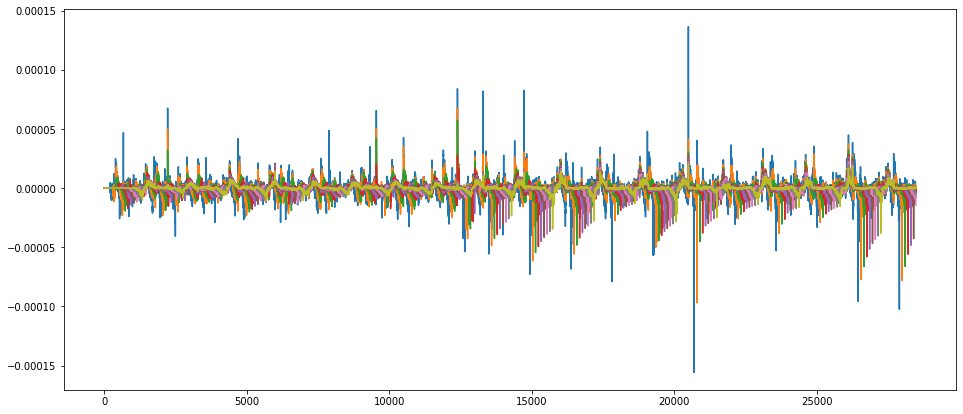

In [23]:
plot_dataset(
    {b.name: b for b in bounds_train},
    figsize=(16, 7),  # min_id=24600, max_id=24750
);

Anomaly score for normal data

In [24]:
{
    ws: bounds_train[i].max()
    for i, ws in enumerate(ws_list)
}

{200: 0    0.000136
 dtype: float64,
 300: 0    0.000067
 dtype: float64,
 400: 0    0.000057
 dtype: float64,
 500: 0    0.000029
 dtype: float64,
 600: 0    0.000026
 dtype: float64,
 700: 0    0.000024
 dtype: float64,
 800: 0    0.000022
 dtype: float64,
 900: 0    0.000021
 dtype: float64,
 1000: 0    0.00002
 dtype: float64}

Anomaly score for anomalies

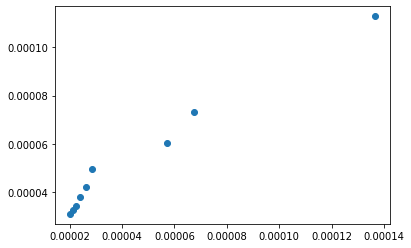

In [42]:
ax = plt.subplot()
x = [
    bounds_train[i].max()
    for i, ws in enumerate(ws_list)
]
y = [
    bounds[i][test_point_cls == 0].max()
    for i, ws in enumerate(ws_list)
]
ax.scatter(x, y);

In [43]:
[y[i]/x[i] for i in range(len(x))]

[0    0.827781
 dtype: float64,
 0    1.083879
 dtype: float64,
 0    1.053982
 dtype: float64,
 0    1.731943
 dtype: float64,
 0    1.613326
 dtype: float64,
 0    1.567106
 dtype: float64,
 0    1.524087
 dtype: float64,
 0    1.524691
 dtype: float64,
 0    1.521004
 dtype: float64]

In [33]:
{
    ws: bounds[i][test_point_cls == 0].max() - bounds_train[i].max()
    for i, ws in enumerate(ws_list)
}

{200: 0   -0.000023
 dtype: float64,
 300: 0    0.000006
 dtype: float64,
 400: 0    0.000003
 dtype: float64,
 500: 0    0.000021
 dtype: float64,
 600: 0    0.000016
 dtype: float64,
 700: 0    0.000014
 dtype: float64,
 800: 0    0.000012
 dtype: float64,
 900: 0    0.000011
 dtype: float64,
 1000: 0    0.000011
 dtype: float64}

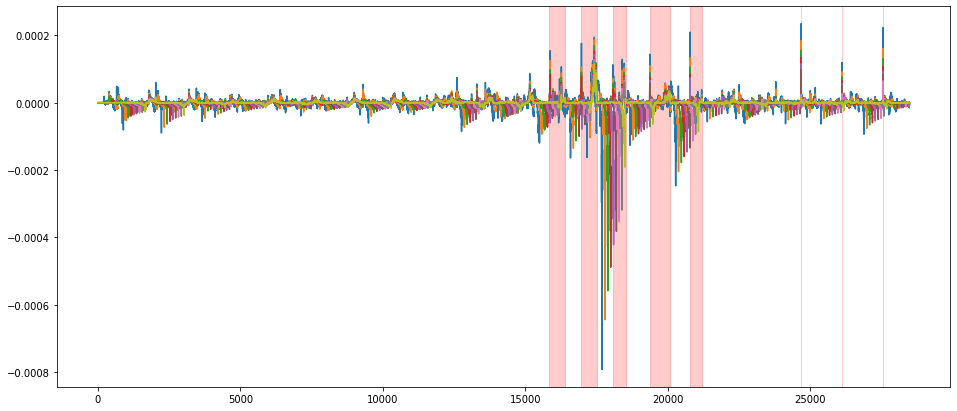

In [28]:
plot_dataset(
    {b.name: b for b in bounds},
    get_ids_ranges(np.where(test_point_cls == 1)[0]),
    figsize=(16, 7),  # min_id=24600, max_id=24750
);

In [78]:
anom_prop = np.where(true_cls == 1)[0].shape[0] / true_cls.shape[0]

0.20785742070087343

In [95]:
int(0.8*len_)

22783

In [104]:
np.sort(bounds[0][0], axis=0)[int(0.8*len_)]

6.029098639798213e-06

In [105]:
tmp_cls.shape

(28479,)

In [106]:
len_ = bounds[0].shape[0]
th = np.sort(bounds[0][0], axis=0)[int(0.8*len_)]
tmp_cls = np.array(bounds[0][0] > th, dtype=int)
fbeta_score(true_cls, tmp_cls[200:], beta=1)

0.33094271148362564

In [115]:
bounds_train[0].iloc[-2000:].mean() + 10*bounds_train[0].std()

0    0.000074
dtype: float64

## Noising train dataset

In [13]:
len_ = train_ds.n_points
df = train_ds.sequences[0].iloc[int(len_ * 0.8):]

In [14]:
art = df.copy()
df_std = df.std()
df_mean = df.mean()
df_max = df.max()

In [30]:
scipy.stats.norm.ppf(0.99), scipy.stats.norm.ppf(0.995)

(2.3263478740408408, 2.5758293035489004)

In [31]:
import scipy
z_f = scipy.stats.norm.ppf(0.999)
art.iloc[4400] = df_mean + z_f * df_std
art.iloc[4401] = df_mean - z_f * df_std

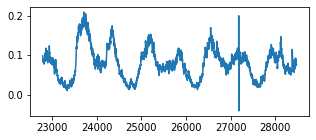

In [32]:
plot_dataset(art[[3]]);

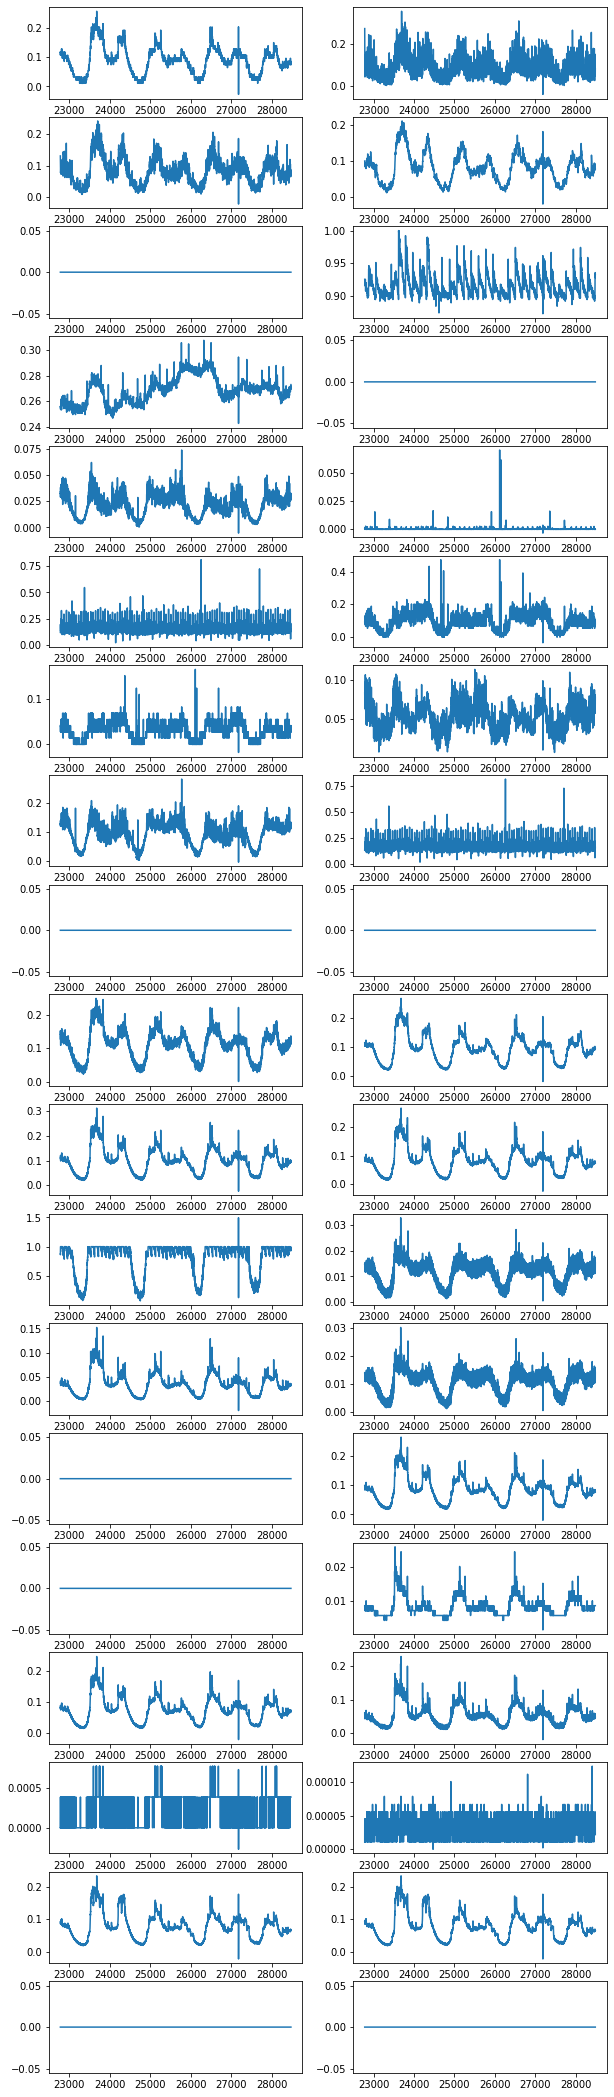

In [18]:
plot_dataset(art);

In [33]:
dl = DataLoader(
    MultiTimeSeriesDataset([df], window_size, target=df.columns.tolist()),
    batch_size=1
)
tmp_a_score = get_a_scores_one_per_point(
    model, dl, window_size, return_only_a_score=True
)

100%|██████████| 5597/5597 [00:05<00:00, 1007.69it/s]


In [34]:
dl = DataLoader(
    MultiTimeSeriesDataset([art], window_size, target=art.columns.tolist()),
    batch_size=1
)
art_a_score = get_a_scores_one_per_point(
    model, dl, window_size, return_only_a_score=True
)

100%|██████████| 5597/5597 [00:05<00:00, 1038.85it/s]


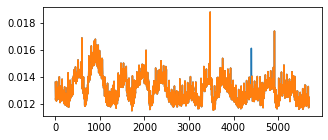

In [35]:
plot_dataset({'art': art_a_score, 'real': tmp_a_score});

In [37]:
ws_list = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
art_bounds = [
    get_diff(get_std(art_a_score, ws))
    for ws in ws_list
]

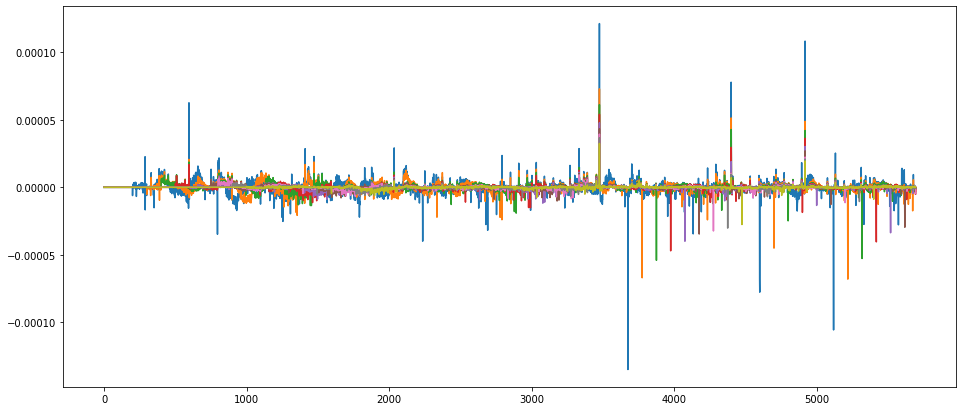

In [38]:
plot_dataset(
    {b.name: b for b in art_bounds},
    figsize=(16, 7),  # min_id=24600, max_id=24750
);

In [39]:
(art_bounds[0].iloc[4395:4405] - art_bounds[0].iloc[4395:4405].mean()) / art_bounds[0].iloc[4395:4405].std()

,0
4395,-0.475109
4396,-0.582121
4397,-0.443626
4398,-0.558030
4399,-0.312170
4400,2.180940
4401,1.563285
4402,-0.481694
4403,-0.447210
4404,-0.444264


In [25]:
th_art_test_best = {
    ws: (
        float(art_bounds[i].iloc[4401]),
        float(bounds[i][test_point_cls == 0].max()),
        float(std_th_df.loc[std_th_df[std_th_df['ws'] == ws]['f1-score'].idxmax()]['th']),
    )  # / art_bounds[i].max()
    for i, ws in enumerate(ws_list)
}

In [26]:
th_art_test_best

{200: (3.3264524410590716e-05, 0.00012514833500117052, 0.00010333333333333333),
 300: (2.4762645675522926e-05, 9.73176582642365e-05, 5.6666666666666664e-05),
 400: (2.1002303223353273e-05, 8.43478305314132e-05, 4.948717948717948e-05),
 500: (1.4705709392309383e-05, 6.684827726294155e-05, 6.025641025641025e-05),
 600: (8.763819405569395e-06, 6.089893049090458e-05, 4.230769230769231e-05),
 700: (4.6675337183900954e-06, 5.565649087088903e-05, 5.6666666666666664e-05),
 800: (4.752889307352488e-06, 5.191195439030959e-05, 2.076923076923077e-05),
 900: (4.4290117576249515e-06, 4.87241194796923e-05, 1.358974358974359e-05),
 1000: (3.1940865246834517e-06, 4.495824684667667e-05, 1.358974358974359e-05)}

### Testing generated thresholds

In [27]:
gen_ths = [(ws, th[0]) for ws, th in th_art_test_best.items()]
wss, ths = list(zip(*gen_ths))
ths_list = [[th] for th in ths]
art_th_exp = stats_experiment(
    test_index, bounds, ths_list=ths_list, ws_list=wss, point_cls=test_point_cls, betas=[0.5, 1.0])

100%|██████████| 9/9 [00:01<00:00,  8.48it/s]


In [28]:
art_th_exp.sort_values('tn', ascending=False)

,ws,th,wdd,f0.5-score,f1.0-score,tn,fp,fn,tp,preds_rec_cls
0,200,0.000033,None,0.540244,0.652546,16161,6241,9,5869,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,300,0.000025,None,0.550743,0.659102,13408,7368,143,7261,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,400,0.000021,None,0.574773,0.682716,11774,7802,53,8451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,500,0.000015,None,0.520943,0.634990,8057,10653,2,9268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,600,0.000009,None,0.463999,0.580725,3758,14252,0,9870,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,900,0.000004,None,0.478941,0.595252,1753,14883,0,10944,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,800,0.000005,None,0.466854,0.583517,1599,15337,0,10744,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,1000,0.000003,None,0.479419,0.595713,1210,15126,0,11144,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,700,0.000005,None,0.447107,0.564056,1126,16184,0,10470,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [29]:
art_th_exp

,ws,th,wdd,f0.5-score,f1.0-score,tn,fp,fn,tp,preds_rec_cls
0,200,0.000033,None,0.540244,0.652546,16161,6241,9,5869,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,300,0.000025,None,0.550743,0.659102,13408,7368,143,7261,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,400,0.000021,None,0.574773,0.682716,11774,7802,53,8451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,500,0.000015,None,0.520943,0.634990,8057,10653,2,9268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,600,0.000009,None,0.463999,0.580725,3758,14252,0,9870,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,700,0.000005,None,0.447107,0.564056,1126,16184,0,10470,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,800,0.000005,None,0.466854,0.583517,1599,15337,0,10744,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,900,0.000004,None,0.478941,0.595252,1753,14883,0,10944,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,1000,0.000003,None,0.479419,0.595713,1210,15126,0,11144,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# SMD experiment interpreting

In [9]:
# exp = load_experimentator('./saved_experiments/2022-06-05_16:27:49.pkl')
exp = load_experimentator('./saved_experiments/2022-06-14_15:36:53.pkl')
# exp = load_experimentator('./saved_experiments/2022-06-05_17:34:24.pkl')
model_id = 0
exp.models_params

,name_,cls_,init_params,WrapperCls,wrapper_kwargs,learning_params
0,AnomTrans_l2_d10_lambda10,<class 'literature.anom_trans.anom_trans.Anoma...,"{'window_size': 200, 'c_in': 38, 'd_model': 10...",<class 'literature.anom_trans.anom_trans_wrapp...,{},"{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
1,AnomTrans_l3_d512_lambda10,<class 'literature.anom_trans.anom_trans.Anoma...,"{'window_size': 200, 'c_in': 38, 'd_model': 51...",<class 'literature.anom_trans.anom_trans_wrapp...,{},"{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."
2,AnomTrans_l3_d512_lambda3,<class 'literature.anom_trans.anom_trans.Anoma...,"{'window_size': 200, 'c_in': 38, 'd_model': 51...",<class 'literature.anom_trans.anom_trans_wrapp...,{},"{'lr': 0.0001, 'criterion': MSELoss(), 'Optimi..."


In [10]:
exp.predictions

,dataset_id,model_id,predictions
0,0,0,0_q000 0_q025 0_q050 0_q075 ...
0,0,1,0_q000 0_q025 0_q050 0_q075 ...
0,0,2,0_q000 0_q025 0_q050 0_q075 ...
0,1,2,0_q000 0_q025 0_q050 0_q075 ...
0,2,2,0_q000 0_q025 0_q050 0_q075 ...
0,3,2,0_q000 0_q025 0_q050 0_q075 ...
0,4,2,0_q000 0_q025 0_q050 0_q075 ...
0,5,2,0_q000 0_q025 0_q050 0_q075 ...
0,6,2,0_q000 0_q025 0_q050 0_q075 ...
